In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [35]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [36]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [37]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [38]:
# For model construction
from collections import OrderedDict

In [39]:
# Import tqdm for progress bar construction
import tqdm

In [40]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [41]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [42]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [43]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'train_metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [44]:
# Class for ff1010 dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Select the middle input from slices
        source = source[N // 2]

        return source, torch.tensor(self.labels[idx], dtype=ltype)
    
    def __len__(self):
        return len(self.dataframe)

In [45]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

In [46]:
import os

# Print period for accuracy.
print_period = 100

# Hyper-parameters for training 
birdclef_batch = 16
birdclef_epoch = 25

# Learning Rate.
learning_rate_1 = 0.0001

# L2 Regularization Hyperparamter
weight_decay_1 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
#        self.googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
        x = self.resnet50(x)
#        x = self.googlenet(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, loss, epoch, index):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, './bird_specificator_Resnet50.pt')

def train_model(model, train_loader, val_loader, optimizer, scheduler, beta=beta, epoch=birdclef_epoch):
    val_losses = []
    train_losses = []
    epoch_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    
    
    for e in range(epoch):
        if e < saved_epoch:
            continue
        
        if len(val_losses) == 0 and saved_epoch > -1:
            acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
            val_losses.append(acc)
            train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
            log_scores.append(log_score)
            fbeta_scores.append(fbeta_score)
            
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # Cosine LR Annealing Scheduler
        scheduler.step()
        
        # every epoch, save the model
        checkpoint(model, optimizer, epoch_losses, e, index)
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\ujubo/.cache\torch\hub\pytorch_vision_v0.10.0


Model2(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [47]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_1, momentum=0.5, weight_decay=weight_decay_1)
#    optimizer = optim.Adam(model.parameters(), lr=learning_rate_1, weight_decay=weight_decay_1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=birdclef_epoch, eta_min=1e-5)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, scheduler, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [48]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [49]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# for i in range(2, 5):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                               | 1/2357 [00:02<1:53:38,  2.89s/it]

Iteration 0, loss = 6.3611


  4%|███▎                                                                         | 101/2357 [04:55<1:52:02,  2.98s/it]

Iteration 100, loss = 6.0820


  9%|██████▌                                                                      | 201/2357 [09:54<1:46:51,  2.97s/it]

Iteration 200, loss = 6.1958


 13%|█████████▊                                                                   | 301/2357 [14:52<1:41:18,  2.96s/it]

Iteration 300, loss = 6.2942


 17%|█████████████                                                                | 401/2357 [19:45<1:37:54,  3.00s/it]

Iteration 400, loss = 6.0740


 21%|████████████████▎                                                            | 501/2357 [24:44<1:33:34,  3.03s/it]

Iteration 500, loss = 6.0767


 25%|███████████████████▋                                                         | 601/2357 [29:32<1:25:55,  2.94s/it]

Iteration 600, loss = 6.0597


 30%|██████████████████████▉                                                      | 701/2357 [34:24<1:20:06,  2.90s/it]

Iteration 700, loss = 6.2667


 34%|██████████████████████████▏                                                  | 801/2357 [39:11<1:15:21,  2.91s/it]

Iteration 800, loss = 5.8085


 38%|█████████████████████████████▍                                               | 901/2357 [43:57<1:06:28,  2.74s/it]

Iteration 900, loss = 5.9099


 42%|████████████████████████████████▎                                           | 1001/2357 [48:49<1:03:55,  2.83s/it]

Iteration 1000, loss = 6.0041


 47%|███████████████████████████████████▌                                        | 1101/2357 [53:38<1:02:58,  3.01s/it]

Iteration 1100, loss = 6.2368


 51%|███████████████████████████████████████▋                                      | 1201/2357 [58:32<58:07,  3.02s/it]

Iteration 1200, loss = 6.2876


 55%|█████████████████████████████████████████▉                                  | 1301/2357 [1:03:02<46:29,  2.64s/it]

Iteration 1300, loss = 5.7587


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:07:23<41:15,  2.59s/it]

Iteration 1400, loss = 5.7421


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:11:45<36:51,  2.58s/it]

Iteration 1500, loss = 6.1755


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:16:06<32:30,  2.58s/it]

Iteration 1600, loss = 6.2476


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:20:27<28:51,  2.64s/it]

Iteration 1700, loss = 5.8538


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:24:46<23:42,  2.56s/it]

Iteration 1800, loss = 5.8871


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:29:05<19:43,  2.60s/it]

Iteration 1900, loss = 5.9401


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:33:25<15:20,  2.59s/it]

Iteration 2000, loss = 5.9041


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:37:46<11:02,  2.59s/it]

Iteration 2100, loss = 6.2800


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:42:09<07:04,  2.72s/it]

Iteration 2200, loss = 6.0800


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:46:25<02:16,  2.43s/it]

Iteration 2300, loss = 5.8742


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:48:51<00:00,  2.77s/it]


Checking accuracy score on validation set.

Accuracy: 148 / 12575 correct (1.18)
Log Loss score:	5.94
Fbeta-score (beta=1): 	0.01
Training model 2, epoch 2


  0%|                                                                               | 1/2357 [00:02<1:41:52,  2.59s/it]

Iteration 0, loss = 5.8918


  4%|███▎                                                                         | 101/2357 [04:16<1:35:59,  2.55s/it]

Iteration 100, loss = 6.0639


  9%|██████▌                                                                      | 201/2357 [08:29<1:29:31,  2.49s/it]

Iteration 200, loss = 6.2925


 13%|█████████▊                                                                   | 301/2357 [12:45<1:27:16,  2.55s/it]

Iteration 300, loss = 5.9018


 17%|█████████████                                                                | 401/2357 [16:59<1:23:15,  2.55s/it]

Iteration 400, loss = 5.7492


 21%|████████████████▎                                                            | 501/2357 [21:14<1:18:14,  2.53s/it]

Iteration 500, loss = 5.7524


 25%|███████████████████▋                                                         | 601/2357 [25:27<1:14:52,  2.56s/it]

Iteration 600, loss = 6.1037


 30%|██████████████████████▉                                                      | 701/2357 [29:40<1:10:12,  2.54s/it]

Iteration 700, loss = 5.8036


 34%|██████████████████████████▏                                                  | 801/2357 [33:53<1:04:16,  2.48s/it]

Iteration 800, loss = 6.0637


 38%|█████████████████████████████▍                                               | 901/2357 [38:06<1:01:58,  2.55s/it]

Iteration 900, loss = 6.2002


 42%|█████████████████████████████████▏                                            | 1001/2357 [42:17<55:46,  2.47s/it]

Iteration 1000, loss = 5.8754


 47%|████████████████████████████████████▍                                         | 1101/2357 [46:36<54:26,  2.60s/it]

Iteration 1100, loss = 5.8504


 51%|███████████████████████████████████████▋                                      | 1201/2357 [50:55<49:14,  2.56s/it]

Iteration 1200, loss = 5.5691


 55%|███████████████████████████████████████████                                   | 1301/2357 [55:13<46:01,  2.61s/it]

Iteration 1300, loss = 5.7963


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [59:33<41:19,  2.59s/it]

Iteration 1400, loss = 5.9615


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:03:56<37:37,  2.64s/it]

Iteration 1500, loss = 5.8829


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:08:08<32:13,  2.56s/it]

Iteration 1600, loss = 5.6924


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:12:25<27:39,  2.53s/it]

Iteration 1700, loss = 5.8123


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:16:43<24:25,  2.64s/it]

Iteration 1800, loss = 5.9227


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:21:01<19:16,  2.54s/it]

Iteration 1900, loss = 5.9068


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:25:19<15:17,  2.58s/it]

Iteration 2000, loss = 5.8110


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:29:34<11:21,  2.66s/it]

Iteration 2100, loss = 5.6142


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:33:53<06:45,  2.60s/it]

Iteration 2200, loss = 5.7477


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:38:11<02:26,  2.62s/it]

Iteration 2300, loss = 5.9366


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:40:36<00:00,  2.56s/it]


Checking accuracy score on validation set.

Accuracy: 245 / 12575 correct (1.95)
Log Loss score:	5.75
Fbeta-score (beta=1): 	0.02
Training model 2, epoch 3


  0%|                                                                               | 1/2357 [00:02<1:45:01,  2.67s/it]

Iteration 0, loss = 5.7282


  4%|███▎                                                                         | 101/2357 [04:20<1:36:19,  2.56s/it]

Iteration 100, loss = 5.5825


  9%|██████▌                                                                      | 201/2357 [08:36<1:31:48,  2.56s/it]

Iteration 200, loss = 5.7174


 13%|█████████▊                                                                   | 301/2357 [12:53<1:27:57,  2.57s/it]

Iteration 300, loss = 5.7045


 17%|█████████████                                                                | 401/2357 [17:12<1:24:42,  2.60s/it]

Iteration 400, loss = 5.6724


 21%|████████████████▎                                                            | 501/2357 [21:32<1:20:52,  2.61s/it]

Iteration 500, loss = 5.9027


 25%|███████████████████▋                                                         | 601/2357 [25:47<1:16:29,  2.61s/it]

Iteration 600, loss = 5.8724


 30%|██████████████████████▉                                                      | 701/2357 [30:04<1:11:29,  2.59s/it]

Iteration 700, loss = 5.8313


 34%|██████████████████████████▏                                                  | 801/2357 [34:20<1:06:31,  2.57s/it]

Iteration 800, loss = 5.7671


 38%|█████████████████████████████▍                                               | 901/2357 [38:39<1:02:27,  2.57s/it]

Iteration 900, loss = 5.8461


 42%|█████████████████████████████████▏                                            | 1001/2357 [42:56<58:23,  2.58s/it]

Iteration 1000, loss = 5.5271


 47%|████████████████████████████████████▍                                         | 1101/2357 [47:12<53:17,  2.55s/it]

Iteration 1100, loss = 5.9270


 51%|███████████████████████████████████████▋                                      | 1201/2357 [51:26<49:36,  2.57s/it]

Iteration 1200, loss = 5.6320


 55%|███████████████████████████████████████████                                   | 1301/2357 [55:43<45:04,  2.56s/it]

Iteration 1300, loss = 5.5599


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [59:58<39:38,  2.49s/it]

Iteration 1400, loss = 5.5295


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:04:11<37:00,  2.59s/it]

Iteration 1500, loss = 5.9008


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:08:25<31:46,  2.52s/it]

Iteration 1600, loss = 5.3782


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:12:40<27:36,  2.53s/it]

Iteration 1700, loss = 5.1370


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:16:56<23:53,  2.58s/it]

Iteration 1800, loss = 5.5070


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:21:14<19:20,  2.54s/it]

Iteration 1900, loss = 5.5439


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:25:30<14:48,  2.50s/it]

Iteration 2000, loss = 5.8065


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:29:45<10:55,  2.56s/it]

Iteration 2100, loss = 5.2108


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:34:01<06:33,  2.52s/it]

Iteration 2200, loss = 5.5410


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:38:16<02:23,  2.56s/it]

Iteration 2300, loss = 5.6556


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:40:40<00:00,  2.56s/it]


Checking accuracy score on validation set.

Accuracy: 443 / 12575 correct (3.52)
Log Loss score:	5.58
Fbeta-score (beta=1): 	0.04
Training model 2, epoch 4


  0%|                                                                               | 1/2357 [00:02<1:44:26,  2.66s/it]

Iteration 0, loss = 5.4508


  4%|███▎                                                                         | 101/2357 [04:19<1:36:47,  2.57s/it]

Iteration 100, loss = 5.7558


  9%|██████▌                                                                      | 201/2357 [08:36<1:32:11,  2.57s/it]

Iteration 200, loss = 5.9020


 13%|█████████▊                                                                   | 301/2357 [12:42<1:21:28,  2.38s/it]

Iteration 300, loss = 5.2638


 17%|█████████████                                                                | 401/2357 [16:42<1:18:03,  2.39s/it]

Iteration 400, loss = 5.3220


 21%|████████████████▎                                                            | 501/2357 [20:42<1:11:43,  2.32s/it]

Iteration 500, loss = 5.0918


 25%|███████████████████▋                                                         | 601/2357 [24:38<1:08:25,  2.34s/it]

Iteration 600, loss = 5.6255


 30%|██████████████████████▉                                                      | 701/2357 [28:45<1:16:25,  2.77s/it]

Iteration 700, loss = 5.6910


 34%|██████████████████████████▏                                                  | 801/2357 [33:32<1:18:13,  3.02s/it]

Iteration 800, loss = 5.4257


 38%|█████████████████████████████▍                                               | 901/2357 [38:24<1:14:14,  3.06s/it]

Iteration 900, loss = 5.5140


 42%|████████████████████████████████▎                                           | 1001/2357 [43:14<1:04:16,  2.84s/it]

Iteration 1000, loss = 5.5024


 47%|████████████████████████████████████▍                                         | 1101/2357 [47:57<59:15,  2.83s/it]

Iteration 1100, loss = 5.4753


 51%|███████████████████████████████████████▋                                      | 1201/2357 [52:40<54:07,  2.81s/it]

Iteration 1200, loss = 5.4369


 55%|███████████████████████████████████████████                                   | 1301/2357 [57:25<50:10,  2.85s/it]

Iteration 1300, loss = 5.0797


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:02:09<45:13,  2.84s/it]

Iteration 1400, loss = 5.5182


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:06:54<39:29,  2.77s/it]

Iteration 1500, loss = 5.0816


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:11:49<36:51,  2.93s/it]

Iteration 1600, loss = 5.4796


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:16:27<29:04,  2.66s/it]

Iteration 1700, loss = 4.9362


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:20:58<27:23,  2.96s/it]

Iteration 1800, loss = 5.4556


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:26:07<22:43,  2.99s/it]

Iteration 1900, loss = 5.5464


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:31:10<18:29,  3.12s/it]

Iteration 2000, loss = 5.5538


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:36:04<12:54,  3.03s/it]

Iteration 2100, loss = 5.2039


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:40:59<07:29,  2.88s/it]

Iteration 2200, loss = 5.7432


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:45:50<02:42,  2.91s/it]

Iteration 2300, loss = 5.7116


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:48:32<00:00,  2.76s/it]


Checking accuracy score on validation set.

Accuracy: 1021 / 12575 correct (8.12)
Log Loss score:	5.21
Fbeta-score (beta=1): 	0.08
Training model 2, epoch 5


  0%|                                                                               | 1/2357 [00:02<1:55:59,  2.95s/it]

Iteration 0, loss = 5.3552


  4%|███▎                                                                         | 101/2357 [04:49<1:47:01,  2.85s/it]

Iteration 100, loss = 4.8964


  9%|██████▌                                                                      | 201/2357 [09:39<1:44:00,  2.89s/it]

Iteration 200, loss = 4.5985


 13%|█████████▊                                                                   | 301/2357 [14:28<1:38:53,  2.89s/it]

Iteration 300, loss = 5.4206


 17%|█████████████                                                                | 401/2357 [19:18<1:33:50,  2.88s/it]

Iteration 400, loss = 5.2823


 21%|████████████████▎                                                            | 501/2357 [24:07<1:37:01,  3.14s/it]

Iteration 500, loss = 4.5440


 25%|███████████████████▋                                                         | 601/2357 [29:04<1:29:55,  3.07s/it]

Iteration 600, loss = 4.7246


 30%|██████████████████████▉                                                      | 701/2357 [33:57<1:15:00,  2.72s/it]

Iteration 700, loss = 5.4762


 34%|██████████████████████████▏                                                  | 801/2357 [38:37<1:13:00,  2.82s/it]

Iteration 800, loss = 4.7150


 38%|█████████████████████████████▍                                               | 901/2357 [43:19<1:04:59,  2.68s/it]

Iteration 900, loss = 6.2284


 42%|████████████████████████████████▎                                           | 1001/2357 [47:53<1:04:40,  2.86s/it]

Iteration 1000, loss = 3.8821


 47%|███████████████████████████████████▌                                        | 1101/2357 [52:48<1:00:38,  2.90s/it]

Iteration 1100, loss = 5.1469


 51%|███████████████████████████████████████▋                                      | 1201/2357 [57:33<54:05,  2.81s/it]

Iteration 1200, loss = 5.1709


 55%|█████████████████████████████████████████▉                                  | 1301/2357 [1:02:17<50:54,  2.89s/it]

Iteration 1300, loss = 5.4138


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:06:59<44:35,  2.80s/it]

Iteration 1400, loss = 4.4651


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:11:44<40:36,  2.85s/it]

Iteration 1500, loss = 4.7144


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:16:30<37:13,  2.95s/it]

Iteration 1600, loss = 5.3130


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:21:12<30:31,  2.79s/it]

Iteration 1700, loss = 5.2395


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:25:39<23:24,  2.53s/it]

Iteration 1800, loss = 5.7928


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:29:55<18:54,  2.49s/it]

Iteration 1900, loss = 5.4922


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:34:09<15:06,  2.55s/it]

Iteration 2000, loss = 4.4255


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:38:23<10:53,  2.55s/it]

Iteration 2100, loss = 4.4084


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:42:35<06:37,  2.55s/it]

Iteration 2200, loss = 4.7594


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:46:53<02:21,  2.53s/it]

Iteration 2300, loss = 4.8833


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:49:14<00:00,  2.78s/it]


Checking accuracy score on validation set.

Accuracy: 1730 / 12575 correct (13.76)
Log Loss score:	4.75
Fbeta-score (beta=1): 	0.14
Training model 2, epoch 6


  0%|                                                                               | 1/2357 [00:02<1:41:48,  2.59s/it]

Iteration 0, loss = 4.4323


  4%|███▎                                                                         | 101/2357 [04:16<1:35:39,  2.54s/it]

Iteration 100, loss = 5.1898


  9%|██████▌                                                                      | 201/2357 [08:27<1:30:32,  2.52s/it]

Iteration 200, loss = 4.6665


 13%|█████████▊                                                                   | 301/2357 [12:38<1:26:44,  2.53s/it]

Iteration 300, loss = 4.0273


 17%|█████████████                                                                | 401/2357 [16:54<1:22:33,  2.53s/it]

Iteration 400, loss = 4.8662


 21%|████████████████▎                                                            | 501/2357 [21:09<1:18:15,  2.53s/it]

Iteration 500, loss = 4.2571


 25%|███████████████████▋                                                         | 601/2357 [25:24<1:14:50,  2.56s/it]

Iteration 600, loss = 5.3384


 30%|██████████████████████▉                                                      | 701/2357 [29:39<1:11:19,  2.58s/it]

Iteration 700, loss = 4.2459


 34%|██████████████████████████▏                                                  | 801/2357 [33:54<1:05:38,  2.53s/it]

Iteration 800, loss = 3.5547


 38%|█████████████████████████████▍                                               | 901/2357 [38:10<1:01:55,  2.55s/it]

Iteration 900, loss = 4.7339


 42%|█████████████████████████████████▏                                            | 1001/2357 [42:27<57:33,  2.55s/it]

Iteration 1000, loss = 4.4971


 47%|████████████████████████████████████▍                                         | 1101/2357 [46:42<52:59,  2.53s/it]

Iteration 1100, loss = 4.4030


 51%|███████████████████████████████████████▋                                      | 1201/2357 [50:57<49:48,  2.59s/it]

Iteration 1200, loss = 4.4754


 55%|███████████████████████████████████████████                                   | 1301/2357 [55:14<46:09,  2.62s/it]

Iteration 1300, loss = 3.9914


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [59:30<40:50,  2.56s/it]

Iteration 1400, loss = 4.7048


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:03:46<36:51,  2.58s/it]

Iteration 1500, loss = 4.5769


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:08:02<31:50,  2.53s/it]

Iteration 1600, loss = 4.3713


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:12:18<27:54,  2.55s/it]

Iteration 1700, loss = 4.2230


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:16:32<23:17,  2.51s/it]

Iteration 1800, loss = 4.0101


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:20:46<19:48,  2.61s/it]

Iteration 1900, loss = 3.9453


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:25:00<14:57,  2.52s/it]

Iteration 2000, loss = 5.0528


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:29:15<10:55,  2.56s/it]

Iteration 2100, loss = 5.2935


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:33:33<06:38,  2.55s/it]

Iteration 2200, loss = 4.3241


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:37:48<02:21,  2.52s/it]

Iteration 2300, loss = 2.9802


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:40:11<00:00,  2.55s/it]


Checking accuracy score on validation set.

Accuracy: 2263 / 12575 correct (18.00)
Log Loss score:	4.36
Fbeta-score (beta=1): 	0.18
Training model 2, epoch 7


  0%|                                                                               | 1/2357 [00:02<1:41:41,  2.59s/it]

Iteration 0, loss = 4.2701


  4%|███▎                                                                         | 101/2357 [04:16<1:37:03,  2.58s/it]

Iteration 100, loss = 3.9252


  9%|██████▌                                                                      | 201/2357 [08:30<1:30:32,  2.52s/it]

Iteration 200, loss = 5.2606


 13%|█████████▊                                                                   | 301/2357 [12:47<1:26:16,  2.52s/it]

Iteration 300, loss = 4.3459


 17%|█████████████                                                                | 401/2357 [16:58<1:23:17,  2.55s/it]

Iteration 400, loss = 3.5979


 21%|████████████████▎                                                            | 501/2357 [21:08<1:16:51,  2.48s/it]

Iteration 500, loss = 5.1921


 25%|███████████████████▋                                                         | 601/2357 [25:21<1:13:56,  2.53s/it]

Iteration 600, loss = 3.6897


 30%|██████████████████████▉                                                      | 701/2357 [29:31<1:10:24,  2.55s/it]

Iteration 700, loss = 3.4843


 34%|██████████████████████████▏                                                  | 801/2357 [33:44<1:07:32,  2.60s/it]

Iteration 800, loss = 4.9916


 38%|█████████████████████████████▍                                               | 901/2357 [37:55<1:00:54,  2.51s/it]

Iteration 900, loss = 2.8550


 42%|█████████████████████████████████▏                                            | 1001/2357 [42:07<57:15,  2.53s/it]

Iteration 1000, loss = 4.4785


 47%|████████████████████████████████████▍                                         | 1101/2357 [46:19<52:36,  2.51s/it]

Iteration 1100, loss = 4.2007


 51%|███████████████████████████████████████▋                                      | 1201/2357 [50:31<48:45,  2.53s/it]

Iteration 1200, loss = 5.0929


 55%|███████████████████████████████████████████                                   | 1301/2357 [54:44<44:23,  2.52s/it]

Iteration 1300, loss = 4.2619


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [58:56<39:45,  2.50s/it]

Iteration 1400, loss = 5.2386


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:03:08<36:18,  2.55s/it]

Iteration 1500, loss = 4.2106


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:07:19<31:56,  2.54s/it]

Iteration 1600, loss = 4.7075


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:11:31<27:29,  2.52s/it]

Iteration 1700, loss = 4.7298


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:15:43<23:12,  2.50s/it]

Iteration 1800, loss = 3.8853


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:19:53<19:02,  2.51s/it]

Iteration 1900, loss = 3.6348


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:24:04<14:50,  2.50s/it]

Iteration 2000, loss = 4.2491


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:28:16<10:36,  2.49s/it]

Iteration 2100, loss = 4.2811


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:32:27<06:35,  2.53s/it]

Iteration 2200, loss = 2.9475


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:36:38<02:21,  2.53s/it]

Iteration 2300, loss = 4.6251


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:38:59<00:00,  2.52s/it]


Checking accuracy score on validation set.

Accuracy: 2786 / 12575 correct (22.16)
Log Loss score:	4.05
Fbeta-score (beta=1): 	0.22
Training model 2, epoch 8


  0%|                                                                               | 1/2357 [00:02<1:43:35,  2.64s/it]

Iteration 0, loss = 2.6111


  4%|███▎                                                                         | 101/2357 [04:13<1:33:59,  2.50s/it]

Iteration 100, loss = 4.1840


  9%|██████▌                                                                      | 201/2357 [08:23<1:30:17,  2.51s/it]

Iteration 200, loss = 4.8571


 13%|█████████▊                                                                   | 301/2357 [12:33<1:25:48,  2.50s/it]

Iteration 300, loss = 3.8040


 17%|█████████████                                                                | 401/2357 [16:46<1:21:45,  2.51s/it]

Iteration 400, loss = 3.8929


 21%|████████████████▎                                                            | 501/2357 [20:58<1:19:23,  2.57s/it]

Iteration 500, loss = 2.9456


 25%|███████████████████▋                                                         | 601/2357 [25:10<1:14:14,  2.54s/it]

Iteration 600, loss = 3.1277


 30%|██████████████████████▉                                                      | 701/2357 [29:23<1:10:07,  2.54s/it]

Iteration 700, loss = 3.2979


 34%|██████████████████████████▏                                                  | 801/2357 [33:31<1:03:49,  2.46s/it]

Iteration 800, loss = 4.4324


 38%|█████████████████████████████▍                                               | 901/2357 [37:42<1:00:39,  2.50s/it]

Iteration 900, loss = 4.6144


 42%|█████████████████████████████████▏                                            | 1001/2357 [41:54<57:17,  2.53s/it]

Iteration 1000, loss = 3.4703


 47%|████████████████████████████████████▍                                         | 1101/2357 [46:05<52:28,  2.51s/it]

Iteration 1100, loss = 3.9542


 51%|███████████████████████████████████████▋                                      | 1201/2357 [50:17<48:16,  2.51s/it]

Iteration 1200, loss = 3.1338


 55%|███████████████████████████████████████████                                   | 1301/2357 [54:28<44:32,  2.53s/it]

Iteration 1300, loss = 2.8524


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [58:41<39:50,  2.50s/it]

Iteration 1400, loss = 3.8880


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:02:52<35:09,  2.46s/it]

Iteration 1500, loss = 3.5723


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:07:02<31:34,  2.51s/it]

Iteration 1600, loss = 3.1949


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:11:13<27:39,  2.53s/it]

Iteration 1700, loss = 4.1570


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:15:26<23:36,  2.55s/it]

Iteration 1800, loss = 3.8209


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:19:40<19:20,  2.55s/it]

Iteration 1900, loss = 4.0846


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:23:53<15:06,  2.55s/it]

Iteration 2000, loss = 3.9263


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:28:05<10:44,  2.52s/it]

Iteration 2100, loss = 3.7160


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:32:20<06:34,  2.53s/it]

Iteration 2200, loss = 3.7185


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:36:33<02:21,  2.53s/it]

Iteration 2300, loss = 3.5320


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:38:54<00:00,  2.52s/it]


Checking accuracy score on validation set.

Accuracy: 3261 / 12575 correct (25.93)
Log Loss score:	3.80
Fbeta-score (beta=1): 	0.26
Training model 2, epoch 9


  0%|                                                                               | 1/2357 [00:02<1:32:53,  2.37s/it]

Iteration 0, loss = 3.8532


  4%|███▎                                                                         | 101/2357 [04:11<1:35:20,  2.54s/it]

Iteration 100, loss = 3.2457


  9%|██████▌                                                                      | 201/2357 [08:20<1:31:20,  2.54s/it]

Iteration 200, loss = 3.6655


 13%|█████████▊                                                                   | 301/2357 [12:30<1:26:43,  2.53s/it]

Iteration 300, loss = 3.1229


 17%|█████████████                                                                | 401/2357 [16:41<1:22:37,  2.53s/it]

Iteration 400, loss = 3.2383


 21%|████████████████▎                                                            | 501/2357 [20:53<1:17:56,  2.52s/it]

Iteration 500, loss = 3.8446


 25%|███████████████████▋                                                         | 601/2357 [25:06<1:12:44,  2.49s/it]

Iteration 600, loss = 3.4098


 30%|██████████████████████▉                                                      | 701/2357 [29:16<1:08:16,  2.47s/it]

Iteration 700, loss = 3.3799


 34%|██████████████████████████▏                                                  | 801/2357 [33:26<1:05:06,  2.51s/it]

Iteration 800, loss = 4.8865


 38%|█████████████████████████████▍                                               | 901/2357 [37:35<1:00:30,  2.49s/it]

Iteration 900, loss = 4.0117


 42%|█████████████████████████████████▏                                            | 1001/2357 [41:43<56:14,  2.49s/it]

Iteration 1000, loss = 4.4442


 47%|████████████████████████████████████▍                                         | 1101/2357 [45:46<50:42,  2.42s/it]

Iteration 1100, loss = 3.8889


 51%|███████████████████████████████████████▋                                      | 1201/2357 [49:48<46:58,  2.44s/it]

Iteration 1200, loss = 3.5463


 55%|███████████████████████████████████████████                                   | 1301/2357 [53:50<42:32,  2.42s/it]

Iteration 1300, loss = 4.5770


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [57:53<38:22,  2.41s/it]

Iteration 1400, loss = 4.2438


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:01:56<33:58,  2.38s/it]

Iteration 1500, loss = 4.1630


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:05:54<30:20,  2.41s/it]

Iteration 1600, loss = 3.2023


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:09:53<26:19,  2.41s/it]

Iteration 1700, loss = 2.7713


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:13:52<22:02,  2.38s/it]

Iteration 1800, loss = 2.8141


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:17:52<18:19,  2.41s/it]

Iteration 1900, loss = 3.9554


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:21:52<14:24,  2.43s/it]

Iteration 2000, loss = 2.5702


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:25:46<09:46,  2.29s/it]

Iteration 2100, loss = 3.4509


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:29:39<06:06,  2.35s/it]

Iteration 2200, loss = 4.8336


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:33:32<02:09,  2.32s/it]

Iteration 2300, loss = 3.5404


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:35:42<00:00,  2.44s/it]


Checking accuracy score on validation set.

Accuracy: 3578 / 12575 correct (28.45)
Log Loss score:	3.65
Fbeta-score (beta=1): 	0.28
Training model 2, epoch 10


  0%|                                                                               | 1/2357 [00:02<1:31:58,  2.34s/it]

Iteration 0, loss = 3.4050


  4%|███▎                                                                         | 101/2357 [03:54<1:27:59,  2.34s/it]

Iteration 100, loss = 4.0994


  9%|██████▌                                                                      | 201/2357 [07:48<1:23:36,  2.33s/it]

Iteration 200, loss = 3.9740


 13%|█████████▊                                                                   | 301/2357 [11:40<1:19:54,  2.33s/it]

Iteration 300, loss = 3.7409


 17%|█████████████                                                                | 401/2357 [15:33<1:16:11,  2.34s/it]

Iteration 400, loss = 3.7299


 21%|████████████████▎                                                            | 501/2357 [19:27<1:11:46,  2.32s/it]

Iteration 500, loss = 3.2097


 25%|███████████████████▋                                                         | 601/2357 [23:20<1:06:58,  2.29s/it]

Iteration 600, loss = 3.2444


 30%|██████████████████████▉                                                      | 701/2357 [27:13<1:05:11,  2.36s/it]

Iteration 700, loss = 2.2396


 34%|██████████████████████████▏                                                  | 801/2357 [31:06<1:00:21,  2.33s/it]

Iteration 800, loss = 3.3683


 38%|██████████████████████████████▏                                                | 901/2357 [34:59<57:40,  2.38s/it]

Iteration 900, loss = 3.9884


 42%|█████████████████████████████████▏                                            | 1001/2357 [38:51<52:31,  2.32s/it]

Iteration 1000, loss = 3.7365


 47%|████████████████████████████████████▍                                         | 1101/2357 [42:45<49:18,  2.36s/it]

Iteration 1100, loss = 2.9211


 51%|███████████████████████████████████████▋                                      | 1201/2357 [46:38<44:32,  2.31s/it]

Iteration 1200, loss = 3.7569


 55%|███████████████████████████████████████████                                   | 1301/2357 [50:31<41:52,  2.38s/it]

Iteration 1300, loss = 3.3421


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [54:25<37:33,  2.36s/it]

Iteration 1400, loss = 4.0926


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:19<33:09,  2.32s/it]

Iteration 1500, loss = 3.9033


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:12<29:01,  2.30s/it]

Iteration 1600, loss = 2.8248


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:04<24:52,  2.27s/it]

Iteration 1700, loss = 2.9586


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:09:59<21:51,  2.36s/it]

Iteration 1800, loss = 2.0958


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:13:53<17:29,  2.30s/it]

Iteration 1900, loss = 2.9354


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:17:48<14:08,  2.38s/it]

Iteration 2000, loss = 2.6907


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:21:42<09:57,  2.34s/it]

Iteration 2100, loss = 2.6246


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:25:36<06:06,  2.35s/it]

Iteration 2200, loss = 3.6257


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:29:30<02:10,  2.33s/it]

Iteration 2300, loss = 3.5271


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:31:42<00:00,  2.33s/it]


Checking accuracy score on validation set.

Accuracy: 4012 / 12575 correct (31.90)
Log Loss score:	3.47
Fbeta-score (beta=1): 	0.32
Training model 2, epoch 11


  0%|                                                                               | 1/2357 [00:02<1:32:56,  2.37s/it]

Iteration 0, loss = 3.2815


  4%|███▎                                                                         | 101/2357 [03:57<1:27:49,  2.34s/it]

Iteration 100, loss = 2.8277


  9%|██████▌                                                                      | 201/2357 [07:51<1:25:01,  2.37s/it]

Iteration 200, loss = 2.8173


 13%|█████████▊                                                                   | 301/2357 [11:48<1:19:52,  2.33s/it]

Iteration 300, loss = 4.2804


 17%|█████████████                                                                | 401/2357 [15:44<1:18:33,  2.41s/it]

Iteration 400, loss = 3.7217


 21%|████████████████▎                                                            | 501/2357 [19:39<1:14:45,  2.42s/it]

Iteration 500, loss = 2.6045


 25%|███████████████████▋                                                         | 601/2357 [23:34<1:08:05,  2.33s/it]

Iteration 600, loss = 4.1204


 30%|██████████████████████▉                                                      | 701/2357 [27:30<1:04:31,  2.34s/it]

Iteration 700, loss = 3.3439


 34%|██████████████████████████▏                                                  | 801/2357 [31:26<1:00:29,  2.33s/it]

Iteration 800, loss = 2.9287


 38%|██████████████████████████████▏                                                | 901/2357 [35:22<58:23,  2.41s/it]

Iteration 900, loss = 3.3703


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:18<53:38,  2.37s/it]

Iteration 1000, loss = 3.0050


 47%|████████████████████████████████████▍                                         | 1101/2357 [43:14<49:27,  2.36s/it]

Iteration 1100, loss = 3.6805


 51%|███████████████████████████████████████▋                                      | 1201/2357 [47:10<45:50,  2.38s/it]

Iteration 1200, loss = 3.2713


 55%|███████████████████████████████████████████                                   | 1301/2357 [51:06<40:31,  2.30s/it]

Iteration 1300, loss = 3.6773


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [55:01<37:26,  2.35s/it]

Iteration 1400, loss = 3.3351


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:56<34:18,  2.40s/it]

Iteration 1500, loss = 2.8697


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:51<29:29,  2.34s/it]

Iteration 1600, loss = 3.2789


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:47<25:56,  2.37s/it]

Iteration 1700, loss = 2.8132


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:10:43<21:46,  2.35s/it]

Iteration 1800, loss = 2.3417


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:37<17:20,  2.28s/it]

Iteration 1900, loss = 3.1162


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:33<13:54,  2.34s/it]

Iteration 2000, loss = 3.5697


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:22:28<10:12,  2.39s/it]

Iteration 2100, loss = 4.1425


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:26:24<06:08,  2.36s/it]

Iteration 2200, loss = 2.4843


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:30:20<02:12,  2.37s/it]

Iteration 2300, loss = 3.8921


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:32:33<00:00,  2.36s/it]


Checking accuracy score on validation set.

Accuracy: 4174 / 12575 correct (33.19)
Log Loss score:	3.40
Fbeta-score (beta=1): 	0.33
Training model 2, epoch 12


  0%|                                                                               | 1/2357 [00:02<1:35:00,  2.42s/it]

Iteration 0, loss = 2.6753


  4%|███▎                                                                         | 101/2357 [03:56<1:28:18,  2.35s/it]

Iteration 100, loss = 2.6104


  9%|██████▌                                                                      | 201/2357 [07:51<1:24:12,  2.34s/it]

Iteration 200, loss = 3.6467


 13%|█████████▊                                                                   | 301/2357 [11:46<1:19:22,  2.32s/it]

Iteration 300, loss = 1.9757


 17%|█████████████                                                                | 401/2357 [15:40<1:18:15,  2.40s/it]

Iteration 400, loss = 3.5636


 21%|████████████████▎                                                            | 501/2357 [19:34<1:13:00,  2.36s/it]

Iteration 500, loss = 3.6839


 25%|███████████████████▋                                                         | 601/2357 [23:27<1:08:30,  2.34s/it]

Iteration 600, loss = 3.1122


 30%|██████████████████████▉                                                      | 701/2357 [27:21<1:05:23,  2.37s/it]

Iteration 700, loss = 2.5286


 34%|██████████████████████████▏                                                  | 801/2357 [31:15<1:02:30,  2.41s/it]

Iteration 800, loss = 2.7905


 38%|██████████████████████████████▏                                                | 901/2357 [35:08<56:52,  2.34s/it]

Iteration 900, loss = 2.1605


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:02<52:29,  2.32s/it]

Iteration 1000, loss = 2.5293


 47%|████████████████████████████████████▍                                         | 1101/2357 [42:57<48:01,  2.29s/it]

Iteration 1100, loss = 3.0461


 51%|███████████████████████████████████████▋                                      | 1201/2357 [46:52<46:20,  2.41s/it]

Iteration 1200, loss = 4.5408


 55%|███████████████████████████████████████████                                   | 1301/2357 [50:46<41:19,  2.35s/it]

Iteration 1300, loss = 3.0355


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [54:41<36:54,  2.32s/it]

Iteration 1400, loss = 2.7679


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:34<33:27,  2.35s/it]

Iteration 1500, loss = 3.0415


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:28<29:09,  2.31s/it]

Iteration 1600, loss = 3.3448


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:22<26:13,  2.40s/it]

Iteration 1700, loss = 2.5409


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:10:16<21:43,  2.34s/it]

Iteration 1800, loss = 3.2408


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:10<17:53,  2.35s/it]

Iteration 1900, loss = 3.4226


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:04<13:44,  2.32s/it]

Iteration 2000, loss = 2.3880


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:21:58<09:58,  2.34s/it]

Iteration 2100, loss = 2.7487


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:25:52<06:06,  2.35s/it]

Iteration 2200, loss = 3.1902


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:29:46<02:13,  2.39s/it]

Iteration 2300, loss = 2.3201


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:31:56<00:00,  2.34s/it]


Checking accuracy score on validation set.

Accuracy: 4383 / 12575 correct (34.85)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 13


  0%|                                                                               | 1/2357 [00:02<1:32:15,  2.35s/it]

Iteration 0, loss = 1.6280


  4%|███▎                                                                         | 101/2357 [03:56<1:29:15,  2.37s/it]

Iteration 100, loss = 3.7398


  9%|██████▌                                                                      | 201/2357 [07:51<1:24:03,  2.34s/it]

Iteration 200, loss = 2.1081


 13%|█████████▊                                                                   | 301/2357 [11:46<1:20:42,  2.36s/it]

Iteration 300, loss = 3.2184


 17%|█████████████                                                                | 401/2357 [15:39<1:14:35,  2.29s/it]

Iteration 400, loss = 2.5327


 21%|████████████████▎                                                            | 501/2357 [19:34<1:12:25,  2.34s/it]

Iteration 500, loss = 2.9537


 25%|███████████████████▋                                                         | 601/2357 [23:29<1:08:10,  2.33s/it]

Iteration 600, loss = 3.4568


 30%|██████████████████████▉                                                      | 701/2357 [27:23<1:05:16,  2.36s/it]

Iteration 700, loss = 2.4821


 34%|██████████████████████████▏                                                  | 801/2357 [31:17<1:00:29,  2.33s/it]

Iteration 800, loss = 2.7330


 38%|██████████████████████████████▏                                                | 901/2357 [35:10<57:08,  2.35s/it]

Iteration 900, loss = 2.4617


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:05<52:09,  2.31s/it]

Iteration 1000, loss = 2.5395


 47%|████████████████████████████████████▍                                         | 1101/2357 [42:59<48:30,  2.32s/it]

Iteration 1100, loss = 3.8331


 51%|███████████████████████████████████████▋                                      | 1201/2357 [46:53<44:21,  2.30s/it]

Iteration 1200, loss = 2.2892


 55%|███████████████████████████████████████████                                   | 1301/2357 [50:48<41:13,  2.34s/it]

Iteration 1300, loss = 2.4023


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [54:43<36:50,  2.31s/it]

Iteration 1400, loss = 3.5709


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:34<33:04,  2.32s/it]

Iteration 1500, loss = 2.5630


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:27<29:30,  2.34s/it]

Iteration 1600, loss = 3.1900


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:19<25:30,  2.33s/it]

Iteration 1700, loss = 2.3529


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:10:12<21:15,  2.29s/it]

Iteration 1800, loss = 2.6089


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:04<17:59,  2.37s/it]

Iteration 1900, loss = 3.7923


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:17:58<13:45,  2.32s/it]

Iteration 2000, loss = 1.8082


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:21:51<09:55,  2.33s/it]

Iteration 2100, loss = 1.9809


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:25:45<06:11,  2.38s/it]

Iteration 2200, loss = 1.7796


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:29:40<02:13,  2.39s/it]

Iteration 2300, loss = 2.7006


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:31:52<00:00,  2.34s/it]


Checking accuracy score on validation set.

Accuracy: 4449 / 12575 correct (35.38)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 14


  0%|                                                                               | 1/2357 [00:02<1:30:46,  2.31s/it]

Iteration 0, loss = 2.2060


  4%|███▎                                                                         | 101/2357 [03:57<1:27:55,  2.34s/it]

Iteration 100, loss = 3.0037


  9%|██████▌                                                                      | 201/2357 [07:52<1:25:13,  2.37s/it]

Iteration 200, loss = 3.8043


 13%|█████████▊                                                                   | 301/2357 [11:47<1:19:18,  2.31s/it]

Iteration 300, loss = 2.7276


 17%|█████████████                                                                | 401/2357 [15:41<1:15:05,  2.30s/it]

Iteration 400, loss = 2.7777


 21%|████████████████▎                                                            | 501/2357 [19:37<1:13:07,  2.36s/it]

Iteration 500, loss = 2.3967


 25%|███████████████████▋                                                         | 601/2357 [23:32<1:09:17,  2.37s/it]

Iteration 600, loss = 3.0181


 30%|██████████████████████▉                                                      | 701/2357 [27:28<1:05:47,  2.38s/it]

Iteration 700, loss = 3.7416


 34%|██████████████████████████▏                                                  | 801/2357 [31:23<1:02:05,  2.39s/it]

Iteration 800, loss = 3.0818


 38%|██████████████████████████████▏                                                | 901/2357 [35:19<57:04,  2.35s/it]

Iteration 900, loss = 2.8837


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:15<52:46,  2.33s/it]

Iteration 1000, loss = 2.6980


 47%|████████████████████████████████████▍                                         | 1101/2357 [43:11<49:15,  2.35s/it]

Iteration 1100, loss = 3.1471


 51%|███████████████████████████████████████▋                                      | 1201/2357 [47:07<46:19,  2.40s/it]

Iteration 1200, loss = 3.3261


 55%|███████████████████████████████████████████                                   | 1301/2357 [51:02<41:40,  2.37s/it]

Iteration 1300, loss = 2.8910


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [54:58<38:29,  2.42s/it]

Iteration 1400, loss = 3.6370


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:55<33:47,  2.37s/it]

Iteration 1500, loss = 4.3352


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:51<29:44,  2.36s/it]

Iteration 1600, loss = 2.2345


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:46<25:59,  2.38s/it]

Iteration 1700, loss = 2.9285


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:10:40<22:17,  2.41s/it]

Iteration 1800, loss = 3.2457


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:36<18:00,  2.37s/it]

Iteration 1900, loss = 2.5713


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:32<13:48,  2.33s/it]

Iteration 2000, loss = 3.1576


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:22:27<10:08,  2.38s/it]

Iteration 2100, loss = 2.7785


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:26:23<06:00,  2.31s/it]

Iteration 2200, loss = 2.3214


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:30:18<02:14,  2.40s/it]

Iteration 2300, loss = 2.7241


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:32:30<00:00,  2.35s/it]


Checking accuracy score on validation set.

Accuracy: 4620 / 12575 correct (36.74)
Log Loss score:	3.20
Fbeta-score (beta=1): 	0.37
Training model 2, epoch 15


  0%|                                                                               | 1/2357 [00:02<1:33:52,  2.39s/it]

Iteration 0, loss = 3.1012


  4%|███▎                                                                         | 101/2357 [03:56<1:27:28,  2.33s/it]

Iteration 100, loss = 2.7569


  9%|██████▌                                                                      | 201/2357 [07:51<1:24:09,  2.34s/it]

Iteration 200, loss = 3.5316


 13%|█████████▊                                                                   | 301/2357 [11:45<1:20:30,  2.35s/it]

Iteration 300, loss = 2.3834


 17%|█████████████                                                                | 401/2357 [15:39<1:16:23,  2.34s/it]

Iteration 400, loss = 3.5291


 21%|████████████████▎                                                            | 501/2357 [19:34<1:11:23,  2.31s/it]

Iteration 500, loss = 3.5295


 25%|███████████████████▋                                                         | 601/2357 [23:29<1:09:35,  2.38s/it]

Iteration 600, loss = 2.2077


 30%|██████████████████████▉                                                      | 701/2357 [27:23<1:04:56,  2.35s/it]

Iteration 700, loss = 2.7303


 34%|██████████████████████████▏                                                  | 801/2357 [31:17<1:01:01,  2.35s/it]

Iteration 800, loss = 2.1453


 38%|██████████████████████████████▏                                                | 901/2357 [35:10<55:01,  2.27s/it]

Iteration 900, loss = 2.8504


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:04<52:49,  2.34s/it]

Iteration 1000, loss = 2.3809


 47%|████████████████████████████████████▍                                         | 1101/2357 [42:58<48:32,  2.32s/it]

Iteration 1100, loss = 2.9806


 51%|███████████████████████████████████████▋                                      | 1201/2357 [46:53<45:38,  2.37s/it]

Iteration 1200, loss = 2.8084


 55%|███████████████████████████████████████████                                   | 1301/2357 [50:47<41:18,  2.35s/it]

Iteration 1300, loss = 2.9373


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [54:41<37:12,  2.34s/it]

Iteration 1400, loss = 2.3508


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:35<34:00,  2.38s/it]

Iteration 1500, loss = 2.0920


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:30<29:21,  2.33s/it]

Iteration 1600, loss = 2.5955


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:25<25:40,  2.35s/it]

Iteration 1700, loss = 2.9711


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:10:19<21:43,  2.34s/it]

Iteration 1800, loss = 2.4776


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:13<17:52,  2.35s/it]

Iteration 1900, loss = 3.0049


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:08<14:02,  2.37s/it]

Iteration 2000, loss = 1.2655


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:22:03<09:57,  2.33s/it]

Iteration 2100, loss = 1.8749


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:25:57<06:02,  2.32s/it]

Iteration 2200, loss = 2.4969


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:29:51<02:12,  2.36s/it]

Iteration 2300, loss = 2.1964


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:32:02<00:00,  2.34s/it]


Checking accuracy score on validation set.

Accuracy: 4725 / 12575 correct (37.57)
Log Loss score:	3.14
Fbeta-score (beta=1): 	0.38
Training model 2, epoch 16


  0%|                                                                               | 1/2357 [00:02<1:32:40,  2.36s/it]

Iteration 0, loss = 3.0393


  4%|███▎                                                                         | 101/2357 [03:56<1:26:13,  2.29s/it]

Iteration 100, loss = 2.4109


  9%|██████▌                                                                      | 201/2357 [07:50<1:23:31,  2.32s/it]

Iteration 200, loss = 2.4266


 13%|█████████▊                                                                   | 301/2357 [11:45<1:22:05,  2.40s/it]

Iteration 300, loss = 3.4444


 17%|█████████████                                                                | 401/2357 [15:40<1:16:08,  2.34s/it]

Iteration 400, loss = 2.0349


 21%|████████████████▎                                                            | 501/2357 [19:34<1:12:24,  2.34s/it]

Iteration 500, loss = 2.7295


 25%|███████████████████▋                                                         | 601/2357 [23:29<1:09:19,  2.37s/it]

Iteration 600, loss = 2.4991


 30%|██████████████████████▉                                                      | 701/2357 [27:23<1:05:01,  2.36s/it]

Iteration 700, loss = 2.2462


 34%|██████████████████████████▏                                                  | 801/2357 [31:17<1:01:05,  2.36s/it]

Iteration 800, loss = 2.2357


 38%|██████████████████████████████▏                                                | 901/2357 [35:11<56:46,  2.34s/it]

Iteration 900, loss = 3.5209


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:04<52:53,  2.34s/it]

Iteration 1000, loss = 2.8148


 47%|████████████████████████████████████▍                                         | 1101/2357 [42:58<48:35,  2.32s/it]

Iteration 1100, loss = 3.7052


 51%|███████████████████████████████████████▋                                      | 1201/2357 [46:51<45:57,  2.39s/it]

Iteration 1200, loss = 2.2121


 55%|███████████████████████████████████████████                                   | 1301/2357 [50:45<40:23,  2.29s/it]

Iteration 1300, loss = 2.8904


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [54:39<36:46,  2.31s/it]

Iteration 1400, loss = 3.7463


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:34<33:23,  2.34s/it]

Iteration 1500, loss = 2.9600


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:28<28:45,  2.28s/it]

Iteration 1600, loss = 2.7849


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:22<25:30,  2.33s/it]

Iteration 1700, loss = 1.8331


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:10:18<21:38,  2.34s/it]

Iteration 1800, loss = 2.3621


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:12<17:44,  2.33s/it]

Iteration 1900, loss = 2.5609


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:07<13:52,  2.34s/it]

Iteration 2000, loss = 1.0474


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:22:01<10:05,  2.36s/it]

Iteration 2100, loss = 2.5915


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:25:55<06:02,  2.33s/it]

Iteration 2200, loss = 3.3719


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:29:49<02:11,  2.34s/it]

Iteration 2300, loss = 2.2798


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:32:01<00:00,  2.34s/it]


Checking accuracy score on validation set.

Accuracy: 4791 / 12575 correct (38.10)
Log Loss score:	3.12
Fbeta-score (beta=1): 	0.38
Training model 2, epoch 17


  0%|                                                                               | 1/2357 [00:02<1:36:08,  2.45s/it]

Iteration 0, loss = 2.3846


  4%|███▎                                                                         | 101/2357 [03:57<1:29:39,  2.38s/it]

Iteration 100, loss = 2.3269


  9%|██████▌                                                                      | 201/2357 [07:51<1:22:21,  2.29s/it]

Iteration 200, loss = 2.4720


 13%|█████████▊                                                                   | 301/2357 [11:45<1:19:46,  2.33s/it]

Iteration 300, loss = 1.4859


 17%|█████████████                                                                | 401/2357 [15:39<1:15:29,  2.32s/it]

Iteration 400, loss = 1.7142


 21%|████████████████▎                                                            | 501/2357 [19:33<1:13:28,  2.38s/it]

Iteration 500, loss = 2.6386


 25%|███████████████████▋                                                         | 601/2357 [23:27<1:07:47,  2.32s/it]

Iteration 600, loss = 2.6189


 30%|██████████████████████▉                                                      | 701/2357 [27:21<1:04:02,  2.32s/it]

Iteration 700, loss = 3.3225


 34%|██████████████████████████▊                                                    | 801/2357 [31:14<58:24,  2.25s/it]

Iteration 800, loss = 3.5686


 38%|██████████████████████████████▏                                                | 901/2357 [35:07<55:27,  2.29s/it]

Iteration 900, loss = 2.1126


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:01<51:47,  2.29s/it]

Iteration 1000, loss = 3.3700


 47%|████████████████████████████████████▍                                         | 1101/2357 [42:56<49:40,  2.37s/it]

Iteration 1100, loss = 2.5813


 51%|███████████████████████████████████████▋                                      | 1201/2357 [46:50<45:54,  2.38s/it]

Iteration 1200, loss = 1.9859


 55%|███████████████████████████████████████████                                   | 1301/2357 [50:45<41:40,  2.37s/it]

Iteration 1300, loss = 2.7224


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [54:39<37:21,  2.34s/it]

Iteration 1400, loss = 2.0987


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:33<33:13,  2.33s/it]

Iteration 1500, loss = 2.2221


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:29<29:38,  2.35s/it]

Iteration 1600, loss = 1.6059


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:21<25:41,  2.35s/it]

Iteration 1700, loss = 2.2012


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:10:16<22:12,  2.40s/it]

Iteration 1800, loss = 1.7508


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:10<17:40,  2.32s/it]

Iteration 1900, loss = 3.0122


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:04<13:57,  2.35s/it]

Iteration 2000, loss = 1.6276


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:21:58<10:09,  2.38s/it]

Iteration 2100, loss = 3.1874


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:25:52<06:07,  2.35s/it]

Iteration 2200, loss = 3.0540


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:29:46<02:10,  2.33s/it]

Iteration 2300, loss = 1.6821


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:31:57<00:00,  2.34s/it]


Checking accuracy score on validation set.

Accuracy: 4924 / 12575 correct (39.16)
Log Loss score:	3.08
Fbeta-score (beta=1): 	0.39
Training model 2, epoch 18


  0%|                                                                               | 1/2357 [00:02<1:37:07,  2.47s/it]

Iteration 0, loss = 1.4168


  4%|███▎                                                                         | 101/2357 [03:55<1:28:20,  2.35s/it]

Iteration 100, loss = 2.4196


  9%|██████▌                                                                      | 201/2357 [07:47<1:22:24,  2.29s/it]

Iteration 200, loss = 2.2085


 13%|█████████▊                                                                   | 301/2357 [11:40<1:21:05,  2.37s/it]

Iteration 300, loss = 3.1742


 17%|█████████████                                                                | 401/2357 [15:33<1:15:31,  2.32s/it]

Iteration 400, loss = 1.4283


 21%|████████████████▎                                                            | 501/2357 [19:27<1:13:19,  2.37s/it]

Iteration 500, loss = 2.1916


 25%|███████████████████▋                                                         | 601/2357 [23:19<1:08:33,  2.34s/it]

Iteration 600, loss = 2.7901


 30%|██████████████████████▉                                                      | 701/2357 [27:11<1:04:25,  2.33s/it]

Iteration 700, loss = 1.9103


 34%|██████████████████████████▏                                                  | 801/2357 [31:04<1:00:15,  2.32s/it]

Iteration 800, loss = 1.9620


 38%|██████████████████████████████▏                                                | 901/2357 [34:58<56:52,  2.34s/it]

Iteration 900, loss = 3.0717


 42%|█████████████████████████████████▏                                            | 1001/2357 [38:51<53:20,  2.36s/it]

Iteration 1000, loss = 2.0325


 47%|████████████████████████████████████▍                                         | 1101/2357 [42:44<48:05,  2.30s/it]

Iteration 1100, loss = 2.8734


 51%|███████████████████████████████████████▋                                      | 1201/2357 [46:35<44:22,  2.30s/it]

Iteration 1200, loss = 2.5455


 55%|███████████████████████████████████████████                                   | 1301/2357 [50:26<40:58,  2.33s/it]

Iteration 1300, loss = 1.3845


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [54:18<36:42,  2.30s/it]

Iteration 1400, loss = 2.1927


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:11<32:27,  2.27s/it]

Iteration 1500, loss = 2.8992


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:03<29:38,  2.35s/it]

Iteration 1600, loss = 2.1750


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:05:56<25:28,  2.33s/it]

Iteration 1700, loss = 2.6479


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:09:48<21:17,  2.30s/it]

Iteration 1800, loss = 2.1180


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:13:41<17:56,  2.36s/it]

Iteration 1900, loss = 2.1727


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:17:34<13:57,  2.35s/it]

Iteration 2000, loss = 2.9493


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:21:24<09:39,  2.26s/it]

Iteration 2100, loss = 2.6364


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:25:17<06:03,  2.33s/it]

Iteration 2200, loss = 1.7349


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:29:10<02:10,  2.34s/it]

Iteration 2300, loss = 2.7551


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:31:20<00:00,  2.33s/it]


Checking accuracy score on validation set.

Accuracy: 4921 / 12575 correct (39.13)
Log Loss score:	3.04
Fbeta-score (beta=1): 	0.39
Training model 2, epoch 19


  0%|                                                                               | 1/2357 [00:02<1:31:48,  2.34s/it]

Iteration 0, loss = 1.9885


  4%|███▎                                                                         | 101/2357 [04:00<1:30:25,  2.40s/it]

Iteration 100, loss = 2.4599


  9%|██████▌                                                                      | 201/2357 [08:09<1:29:36,  2.49s/it]

Iteration 200, loss = 2.5086


 13%|█████████▊                                                                   | 301/2357 [12:16<1:23:01,  2.42s/it]

Iteration 300, loss = 2.0026


 17%|█████████████                                                                | 401/2357 [16:23<1:18:48,  2.42s/it]

Iteration 400, loss = 2.4094


 21%|████████████████▎                                                            | 501/2357 [20:32<1:18:04,  2.52s/it]

Iteration 500, loss = 3.0984


 25%|███████████████████▋                                                         | 601/2357 [24:41<1:12:18,  2.47s/it]

Iteration 600, loss = 1.7068


 30%|██████████████████████▉                                                      | 701/2357 [28:49<1:07:47,  2.46s/it]

Iteration 700, loss = 1.0305


 34%|██████████████████████████▏                                                  | 801/2357 [32:57<1:04:06,  2.47s/it]

Iteration 800, loss = 1.7741


 38%|██████████████████████████████▏                                                | 901/2357 [37:06<59:42,  2.46s/it]

Iteration 900, loss = 2.6513


 42%|█████████████████████████████████▏                                            | 1001/2357 [41:15<56:02,  2.48s/it]

Iteration 1000, loss = 1.7367


 47%|████████████████████████████████████▍                                         | 1101/2357 [45:23<51:20,  2.45s/it]

Iteration 1100, loss = 1.8280


 51%|███████████████████████████████████████▋                                      | 1201/2357 [49:31<47:55,  2.49s/it]

Iteration 1200, loss = 1.7065


 55%|███████████████████████████████████████████                                   | 1301/2357 [53:33<41:46,  2.37s/it]

Iteration 1300, loss = 2.7094


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [57:44<41:17,  2.59s/it]

Iteration 1400, loss = 1.3710


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:02:23<39:01,  2.74s/it]

Iteration 1500, loss = 1.5254


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:07:06<34:55,  2.77s/it]

Iteration 1600, loss = 3.9847


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:11:50<30:15,  2.77s/it]

Iteration 1700, loss = 1.4885


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:16:45<26:34,  2.87s/it]

Iteration 1800, loss = 2.7085


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:21:36<22:50,  3.01s/it]

Iteration 1900, loss = 2.7273


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:26:29<18:04,  3.05s/it]

Iteration 2000, loss = 2.3573


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:31:25<12:34,  2.95s/it]

Iteration 2100, loss = 2.8525


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:36:25<07:46,  2.99s/it]

Iteration 2200, loss = 3.0622


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:41:22<02:48,  3.02s/it]

Iteration 2300, loss = 1.8485


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:44:08<00:00,  2.65s/it]


Checking accuracy score on validation set.

Accuracy: 5048 / 12575 correct (40.14)
Log Loss score:	3.03
Fbeta-score (beta=1): 	0.40
Training model 2, epoch 20


  0%|                                                                               | 1/2357 [00:02<1:54:37,  2.92s/it]

Iteration 0, loss = 2.4832


  4%|███▎                                                                         | 101/2357 [04:52<1:47:39,  2.86s/it]

Iteration 100, loss = 2.7434


  9%|██████▌                                                                      | 201/2357 [09:36<1:42:11,  2.84s/it]

Iteration 200, loss = 3.6235


 13%|█████████▊                                                                   | 301/2357 [14:22<1:37:46,  2.85s/it]

Iteration 300, loss = 2.6594


 17%|█████████████                                                                | 401/2357 [19:09<1:44:48,  3.21s/it]

Iteration 400, loss = 2.5137


 21%|████████████████▎                                                            | 501/2357 [23:48<1:25:37,  2.77s/it]

Iteration 500, loss = 0.8969


 25%|███████████████████▋                                                         | 601/2357 [28:40<1:21:01,  2.77s/it]

Iteration 600, loss = 1.8565


 30%|██████████████████████▉                                                      | 701/2357 [33:27<1:13:06,  2.65s/it]

Iteration 700, loss = 2.1460


 34%|██████████████████████████▏                                                  | 801/2357 [38:14<1:13:09,  2.82s/it]

Iteration 800, loss = 2.6757


 38%|█████████████████████████████▍                                               | 901/2357 [42:59<1:11:12,  2.93s/it]

Iteration 900, loss = 3.3635


 42%|████████████████████████████████▎                                           | 1001/2357 [47:54<1:06:05,  2.92s/it]

Iteration 1000, loss = 1.7537


 47%|███████████████████████████████████▌                                        | 1101/2357 [52:49<1:02:11,  2.97s/it]

Iteration 1100, loss = 2.9100


 51%|███████████████████████████████████████▋                                      | 1201/2357 [57:45<58:44,  3.05s/it]

Iteration 1200, loss = 1.4930


 55%|█████████████████████████████████████████▉                                  | 1301/2357 [1:02:41<52:12,  2.97s/it]

Iteration 1300, loss = 2.1966


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:07:22<41:22,  2.60s/it]

Iteration 1400, loss = 1.9937


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:11:40<37:04,  2.60s/it]

Iteration 1500, loss = 2.3911


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:15:58<32:28,  2.58s/it]

Iteration 1600, loss = 2.6115


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:20:14<27:59,  2.56s/it]

Iteration 1700, loss = 2.0583


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:24:34<24:27,  2.64s/it]

Iteration 1800, loss = 1.1559


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:28:51<19:31,  2.57s/it]

Iteration 1900, loss = 2.6893


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:33:08<15:33,  2.62s/it]

Iteration 2000, loss = 1.4376


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:37:25<10:53,  2.55s/it]

Iteration 2100, loss = 1.5841


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:41:41<06:43,  2.59s/it]

Iteration 2200, loss = 1.7361


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:46:00<02:28,  2.66s/it]

Iteration 2300, loss = 3.0931


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:48:26<00:00,  2.76s/it]


Checking accuracy score on validation set.

Accuracy: 5102 / 12575 correct (40.57)
Log Loss score:	3.04
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 21


  0%|                                                                               | 1/2357 [00:02<1:44:30,  2.66s/it]

Iteration 0, loss = 1.7835


  4%|███▎                                                                         | 101/2357 [04:25<1:38:16,  2.61s/it]

Iteration 100, loss = 1.4735


  9%|██████▌                                                                      | 201/2357 [08:46<1:33:08,  2.59s/it]

Iteration 200, loss = 1.9086


 13%|█████████▊                                                                   | 301/2357 [13:10<1:29:34,  2.61s/it]

Iteration 300, loss = 2.0907


 17%|█████████████                                                                | 401/2357 [17:32<1:25:43,  2.63s/it]

Iteration 400, loss = 1.5897


 21%|████████████████▎                                                            | 501/2357 [21:55<1:22:37,  2.67s/it]

Iteration 500, loss = 2.2329


 25%|███████████████████▋                                                         | 601/2357 [26:19<1:16:59,  2.63s/it]

Iteration 600, loss = 1.9334


 30%|██████████████████████▉                                                      | 701/2357 [30:41<1:09:28,  2.52s/it]

Iteration 700, loss = 2.8203


 34%|██████████████████████████▏                                                  | 801/2357 [35:05<1:08:12,  2.63s/it]

Iteration 800, loss = 1.9379


 38%|█████████████████████████████▍                                               | 901/2357 [39:29<1:03:28,  2.62s/it]

Iteration 900, loss = 2.5558


 42%|█████████████████████████████████▏                                            | 1001/2357 [43:52<59:16,  2.62s/it]

Iteration 1000, loss = 1.7007


 47%|████████████████████████████████████▍                                         | 1101/2357 [48:15<55:50,  2.67s/it]

Iteration 1100, loss = 1.8242


 51%|███████████████████████████████████████▋                                      | 1201/2357 [52:40<49:46,  2.58s/it]

Iteration 1200, loss = 2.5073


 55%|███████████████████████████████████████████                                   | 1301/2357 [57:02<47:56,  2.72s/it]

Iteration 1300, loss = 3.1149


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:01:25<41:48,  2.62s/it]

Iteration 1400, loss = 2.5623


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:05:46<36:21,  2.55s/it]

Iteration 1500, loss = 2.5494


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:10:07<32:48,  2.60s/it]

Iteration 1600, loss = 1.4003


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:14:27<27:46,  2.54s/it]

Iteration 1700, loss = 2.0189


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:18:46<24:15,  2.62s/it]

Iteration 1800, loss = 2.3222


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:23:07<20:01,  2.64s/it]

Iteration 1900, loss = 3.5981


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:27:27<15:30,  2.61s/it]

Iteration 2000, loss = 1.9634


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:31:49<11:03,  2.59s/it]

Iteration 2100, loss = 2.3036


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:36:01<06:18,  2.42s/it]

Iteration 2200, loss = 2.1397


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:40:11<02:20,  2.52s/it]

Iteration 2300, loss = 1.4610


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:42:31<00:00,  2.61s/it]


Checking accuracy score on validation set.

Accuracy: 5118 / 12575 correct (40.70)
Log Loss score:	3.01
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 22


  0%|                                                                               | 1/2357 [00:02<1:39:44,  2.54s/it]

Iteration 0, loss = 1.6372


  4%|███▎                                                                         | 101/2357 [04:13<1:32:34,  2.46s/it]

Iteration 100, loss = 2.5778


  9%|██████▌                                                                      | 201/2357 [08:21<1:30:19,  2.51s/it]

Iteration 200, loss = 2.1921


 13%|█████████▊                                                                   | 301/2357 [12:31<1:29:32,  2.61s/it]

Iteration 300, loss = 2.0489


 17%|█████████████                                                                | 401/2357 [16:44<1:20:54,  2.48s/it]

Iteration 400, loss = 0.8187


 21%|████████████████▎                                                            | 501/2357 [20:55<1:17:53,  2.52s/it]

Iteration 500, loss = 2.6083


 25%|███████████████████▋                                                         | 601/2357 [25:07<1:13:00,  2.49s/it]

Iteration 600, loss = 2.7625


 30%|██████████████████████▉                                                      | 701/2357 [29:18<1:08:34,  2.48s/it]

Iteration 700, loss = 1.4980


 34%|██████████████████████████▏                                                  | 801/2357 [33:29<1:05:02,  2.51s/it]

Iteration 800, loss = 2.1808


 38%|█████████████████████████████▍                                               | 901/2357 [37:41<1:00:23,  2.49s/it]

Iteration 900, loss = 2.4394


 42%|█████████████████████████████████▏                                            | 1001/2357 [41:53<56:52,  2.52s/it]

Iteration 1000, loss = 1.9110


 47%|████████████████████████████████████▍                                         | 1101/2357 [46:02<52:08,  2.49s/it]

Iteration 1100, loss = 1.4396


 51%|███████████████████████████████████████▋                                      | 1201/2357 [50:11<48:05,  2.50s/it]

Iteration 1200, loss = 1.3712


 55%|███████████████████████████████████████████                                   | 1301/2357 [54:18<43:38,  2.48s/it]

Iteration 1300, loss = 2.8385


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [58:25<39:20,  2.47s/it]

Iteration 1400, loss = 2.5665


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:02:31<34:54,  2.45s/it]

Iteration 1500, loss = 1.2861


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:06:36<30:25,  2.41s/it]

Iteration 1600, loss = 2.3208


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:10:40<26:30,  2.42s/it]

Iteration 1700, loss = 1.5712


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:14:45<22:24,  2.42s/it]

Iteration 1800, loss = 1.7738


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:18:50<18:23,  2.42s/it]

Iteration 1900, loss = 1.5997


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:22:56<14:44,  2.48s/it]

Iteration 2000, loss = 2.4284


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:27:02<10:25,  2.44s/it]

Iteration 2100, loss = 2.4172


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:31:07<06:20,  2.44s/it]

Iteration 2200, loss = 2.4191


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:35:12<02:16,  2.44s/it]

Iteration 2300, loss = 1.5560


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:37:29<00:00,  2.48s/it]


Checking accuracy score on validation set.

Accuracy: 5172 / 12575 correct (41.13)
Log Loss score:	3.00
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 23


  0%|                                                                               | 1/2357 [00:02<1:37:33,  2.48s/it]

Iteration 0, loss = 2.8020


  4%|███▎                                                                         | 101/2357 [04:06<1:30:27,  2.41s/it]

Iteration 100, loss = 1.5549


  9%|██████▌                                                                      | 201/2357 [08:09<1:27:28,  2.43s/it]

Iteration 200, loss = 3.3004


 13%|█████████▊                                                                   | 301/2357 [12:13<1:25:02,  2.48s/it]

Iteration 300, loss = 1.7298


 17%|█████████████                                                                | 401/2357 [16:18<1:20:00,  2.45s/it]

Iteration 400, loss = 2.9032


 21%|████████████████▎                                                            | 501/2357 [20:23<1:15:38,  2.45s/it]

Iteration 500, loss = 1.2811


 25%|███████████████████▋                                                         | 601/2357 [24:26<1:09:35,  2.38s/it]

Iteration 600, loss = 2.2770


 30%|██████████████████████▉                                                      | 701/2357 [28:31<1:08:55,  2.50s/it]

Iteration 700, loss = 1.9881


 34%|██████████████████████████▏                                                  | 801/2357 [32:39<1:04:26,  2.49s/it]

Iteration 800, loss = 0.7754


 38%|██████████████████████████████▏                                                | 901/2357 [36:44<59:10,  2.44s/it]

Iteration 900, loss = 1.8064


 42%|█████████████████████████████████▏                                            | 1001/2357 [40:49<55:39,  2.46s/it]

Iteration 1000, loss = 2.5825


 47%|████████████████████████████████████▍                                         | 1101/2357 [44:53<50:43,  2.42s/it]

Iteration 1100, loss = 2.7156


 51%|███████████████████████████████████████▋                                      | 1201/2357 [49:00<48:07,  2.50s/it]

Iteration 1200, loss = 2.5638


 55%|███████████████████████████████████████████                                   | 1301/2357 [53:12<45:15,  2.57s/it]

Iteration 1300, loss = 3.5433


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [57:23<39:12,  2.46s/it]

Iteration 1400, loss = 2.0838


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:01:30<36:20,  2.55s/it]

Iteration 1500, loss = 2.2310


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:05:37<30:18,  2.41s/it]

Iteration 1600, loss = 2.2832


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:09:45<28:16,  2.59s/it]

Iteration 1700, loss = 2.1221


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:13:52<22:37,  2.44s/it]

Iteration 1800, loss = 2.7756


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:17:59<19:17,  2.54s/it]

Iteration 1900, loss = 1.7630


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:22:08<14:29,  2.44s/it]

Iteration 2000, loss = 1.7553


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:26:09<10:28,  2.46s/it]

Iteration 2100, loss = 2.1439


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:30:13<06:14,  2.40s/it]

Iteration 2200, loss = 1.4845


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:34:17<02:19,  2.49s/it]

Iteration 2300, loss = 3.0156


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:36:37<00:00,  2.46s/it]


Checking accuracy score on validation set.

Accuracy: 5164 / 12575 correct (41.07)
Log Loss score:	2.99
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 24


  0%|                                                                               | 1/2357 [00:02<1:40:52,  2.57s/it]

Iteration 0, loss = 0.9964


  4%|███▎                                                                         | 101/2357 [04:07<1:31:37,  2.44s/it]

Iteration 100, loss = 2.2477


  9%|██████▌                                                                      | 201/2357 [08:16<1:30:17,  2.51s/it]

Iteration 200, loss = 2.3714


 13%|█████████▊                                                                   | 301/2357 [12:25<1:27:29,  2.55s/it]

Iteration 300, loss = 4.1129


 17%|█████████████                                                                | 401/2357 [16:35<1:20:59,  2.48s/it]

Iteration 400, loss = 3.1943


 21%|████████████████▎                                                            | 501/2357 [20:44<1:16:28,  2.47s/it]

Iteration 500, loss = 1.3841


 25%|███████████████████▋                                                         | 601/2357 [24:52<1:12:08,  2.46s/it]

Iteration 600, loss = 3.1255


 30%|██████████████████████▉                                                      | 701/2357 [28:58<1:07:15,  2.44s/it]

Iteration 700, loss = 2.9345


 34%|██████████████████████████▏                                                  | 801/2357 [33:11<1:07:09,  2.59s/it]

Iteration 800, loss = 1.8477


 38%|█████████████████████████████▍                                               | 901/2357 [37:28<1:01:43,  2.54s/it]

Iteration 900, loss = 1.9350


 42%|█████████████████████████████████▏                                            | 1001/2357 [41:45<57:44,  2.56s/it]

Iteration 1000, loss = 2.0067


 47%|████████████████████████████████████▍                                         | 1101/2357 [46:00<54:13,  2.59s/it]

Iteration 1100, loss = 1.6094


 51%|███████████████████████████████████████▋                                      | 1201/2357 [50:17<49:32,  2.57s/it]

Iteration 1200, loss = 2.0491


 55%|███████████████████████████████████████████                                   | 1301/2357 [54:33<45:03,  2.56s/it]

Iteration 1300, loss = 2.4585


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [58:50<40:38,  2.55s/it]

Iteration 1400, loss = 2.0767


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:03:06<36:15,  2.54s/it]

Iteration 1500, loss = 2.4111


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:07:19<31:29,  2.50s/it]

Iteration 1600, loss = 2.3770


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:11:43<31:38,  2.89s/it]

Iteration 1700, loss = 1.9877


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:16:02<23:24,  2.53s/it]

Iteration 1800, loss = 3.1116


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:20:17<19:06,  2.51s/it]

Iteration 1900, loss = 3.1756


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:24:34<14:55,  2.52s/it]

Iteration 2000, loss = 2.1523


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:28:46<10:45,  2.52s/it]

Iteration 2100, loss = 1.4293


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:32:58<06:37,  2.55s/it]

Iteration 2200, loss = 2.5864


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:37:13<02:25,  2.60s/it]

Iteration 2300, loss = 2.5119


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:39:36<00:00,  2.54s/it]


Checking accuracy score on validation set.

Accuracy: 5201 / 12575 correct (41.36)
Log Loss score:	2.99
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 25


  0%|                                                                               | 1/2357 [00:02<1:40:46,  2.57s/it]

Iteration 0, loss = 2.1232


  4%|███▎                                                                         | 101/2357 [04:14<1:46:43,  2.84s/it]

Iteration 100, loss = 1.1310


  9%|██████▌                                                                      | 201/2357 [08:22<1:27:23,  2.43s/it]

Iteration 200, loss = 2.0983


 13%|█████████▊                                                                   | 301/2357 [12:30<1:25:29,  2.50s/it]

Iteration 300, loss = 2.1477


 17%|█████████████                                                                | 401/2357 [16:52<1:28:27,  2.71s/it]

Iteration 400, loss = 1.8195


 21%|████████████████▎                                                            | 501/2357 [21:17<1:21:15,  2.63s/it]

Iteration 500, loss = 2.0133


 25%|███████████████████▋                                                         | 601/2357 [25:41<1:17:29,  2.65s/it]

Iteration 600, loss = 1.6243


 30%|██████████████████████▉                                                      | 701/2357 [30:07<1:12:46,  2.64s/it]

Iteration 700, loss = 2.5666


 34%|██████████████████████████▏                                                  | 801/2357 [34:31<1:09:13,  2.67s/it]

Iteration 800, loss = 2.4100


 38%|█████████████████████████████▍                                               | 901/2357 [38:56<1:03:04,  2.60s/it]

Iteration 900, loss = 1.8036


 42%|████████████████████████████████▎                                           | 1001/2357 [43:21<1:00:13,  2.66s/it]

Iteration 1000, loss = 3.4164


 47%|████████████████████████████████████▍                                         | 1101/2357 [47:47<55:14,  2.64s/it]

Iteration 1100, loss = 1.0043


 51%|███████████████████████████████████████▋                                      | 1201/2357 [52:14<51:28,  2.67s/it]

Iteration 1200, loss = 2.1386


 55%|███████████████████████████████████████████                                   | 1301/2357 [56:34<46:00,  2.61s/it]

Iteration 1300, loss = 3.0966


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:00:53<41:41,  2.62s/it]

Iteration 1400, loss = 2.5223


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:05:13<36:39,  2.57s/it]

Iteration 1500, loss = 1.7470


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:09:32<32:46,  2.60s/it]

Iteration 1600, loss = 2.6615


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:13:52<28:30,  2.61s/it]

Iteration 1700, loss = 2.9995


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:18:11<24:06,  2.60s/it]

Iteration 1800, loss = 2.7977


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:22:32<19:47,  2.60s/it]

Iteration 1900, loss = 1.3354


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:26:51<15:35,  2.63s/it]

Iteration 2000, loss = 2.6734


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:31:09<11:07,  2.61s/it]

Iteration 2100, loss = 3.1599


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:35:27<06:38,  2.55s/it]

Iteration 2200, loss = 2.1740


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:39:47<02:21,  2.53s/it]

Iteration 2300, loss = 1.3517


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:42:12<00:00,  2.60s/it]


Checking accuracy score on validation set.

Accuracy: 5209 / 12575 correct (41.42)
Log Loss score:	2.99
Fbeta-score (beta=1): 	0.41
Checking accuracy score on validation set.

Accuracy: 5211 / 12575 correct (41.44)
Log Loss score:	2.99
Fbeta-score (beta=1): 	0.41


Text(0.5, 1.0, 'Train Loss Curve of Bird Species Classifier')

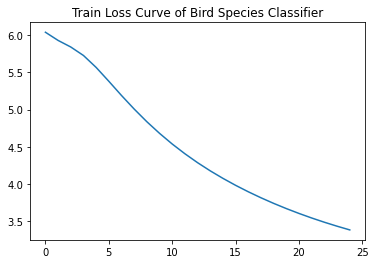

In [50]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Bird Species Classifier')

Text(0.5, 1.0, 'Validation Accuracy Curve of Bird Species Classifier')

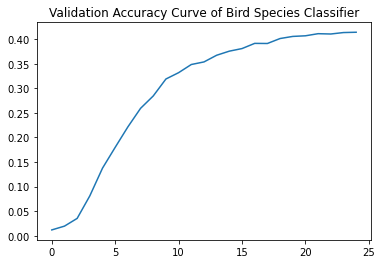

In [51]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Bird Species Classifier')

Text(0.5, 1.0, 'Log-score Curve of Bird Species Classifier')

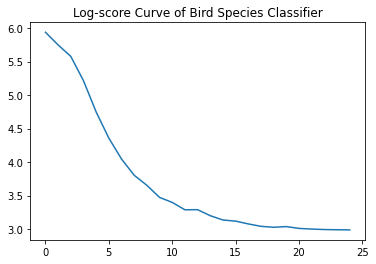

In [52]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Bird Species Classifier')

Text(0.5, 1.0, 'F-beta score Curve of Bird Species Classifier')

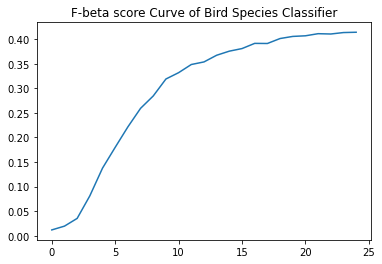

In [53]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Bird Species Classifier')

In [54]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 41.44
Log Loss score:	2.99
Fbeta-score (beta=1.0): 	0.41
